In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set visualization style
sns.set(style="whitegrid")
%matplotlib inline

# Load the datasets
df_feedback = pd.read_csv('Customer_Feedback_Data.csv')
df_transaction = pd.read_csv('Transaction_Data.csv')

print("Data loaded successfully.")

Data loaded successfully.


In [9]:
# 1. Handle Missing Values robustly (using median to avoid outlier distortion)
df_transaction['Transaction_Amount'] = df_transaction['Transaction_Amount'].fillna(df_transaction['Transaction_Amount'].median())
df_feedback['Satisfaction_Score'] = df_feedback['Satisfaction_Score'].fillna(df_feedback['Satisfaction_Score'].median())
df_feedback['Likelihood_to_Recommend'] = df_feedback['Likelihood_to_Recommend'].fillna(df_feedback['Likelihood_to_Recommend'].median())

# 2. Fix Human-Entry Errors in Satisfaction Score (e.g., typing '80' instead of '8.0')
df_feedback['Satisfaction_Score'] = df_feedback['Satisfaction_Score'].apply(lambda x: x/10 if x > 10 else x)
df_feedback['Satisfaction_Score'] = df_feedback['Satisfaction_Score'].clip(upper=10) # Cap at maximum of 10

# 3. Aggregate Transactions per Customer
customer_spend = df_transaction.groupby('Customer_ID').agg(
    Total_Spending=('Transaction_Amount', 'sum'),
    Transaction_Frequency=('Transaction_Amount', 'count')
).reset_index()

# 4. Aggregate Feedback per Customer
customer_feedback = df_feedback.groupby('Customer_ID').agg(
    Average_Satisfaction=('Satisfaction_Score', 'mean'),
    Average_Recommendation=('Likelihood_to_Recommend', 'mean')
).reset_index()

# 5. Merge into a single Customer Master Table
df_customer = pd.merge(customer_spend, customer_feedback, on='Customer_ID', how='inner')

print(f"Aggregated data down to {df_customer.shape[0]} unique customers.")
df_customer.head()

Aggregated data down to 993 unique customers.


,Customer_ID,Total_Spending,Transaction_Frequency,Average_Satisfaction,Average_Recommendation
0,1,16836.0,6,8.500000,9.000000
1,2,4907.0,2,4.333333,5.000000
2,3,1538.0,1,8.333333,3.666667
3,4,8295.0,2,5.500000,3.333333
4,5,14798.0,5,6.444444,5.666667


In [10]:
# 1. Apply Log Transformation to handle heavy right-skew in financial spending
# This prevents extreme "whale" spenders from ruining the cluster distances
df_customer['Log_Total_Spending'] = np.log1p(df_customer['Total_Spending'])

# 2. Select the final features for clustering
features = ['Log_Total_Spending', 'Transaction_Frequency', 'Average_Satisfaction', 'Average_Recommendation']

# Create a clean dataframe for clustering
df_cluster_ready = df_customer.dropna(subset=features).copy()

# 3. Standardize the data so Spend and Satisfaction have equal mathematical weight
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_ready[features])
b
print("Data successfully transformed and scaled. Ready for K-Means.")

Data successfully transformed and scaled. Ready for K-Means.


C:\Users\ramos\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ramos\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ramos\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ramos\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

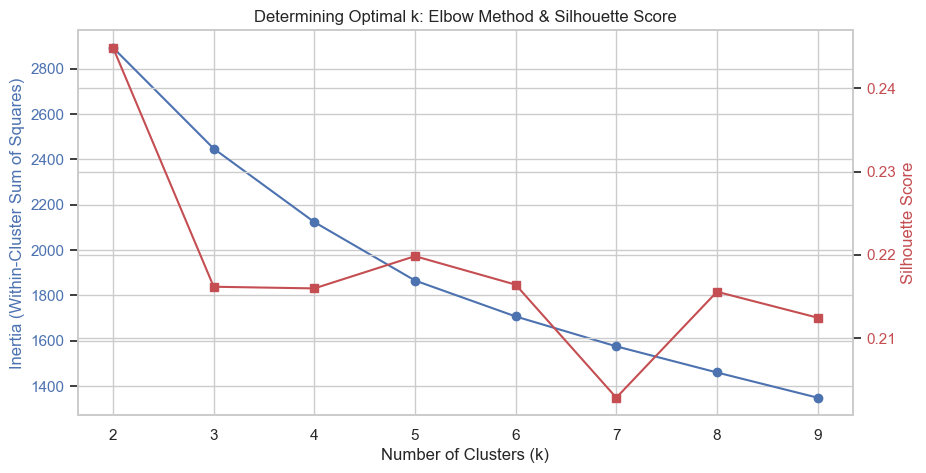

In [11]:
inertia = []
silhouette_scores = []
K_range = range(2, 10)

# Loop through potential cluster numbers
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Inertia (Elbow Method)
ax1.plot(K_range, inertia, marker='o', color='b', label='Inertia (Elbow)')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot Silhouette Score
ax2 = ax1.twinx()
ax2.plot(K_range, silhouette_scores, marker='s', color='r', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Determining Optimal k: Elbow Method & Silhouette Score')
plt.show()

In [12]:
# Fit the final model with k=4 based on our business strategy
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)

# Assign the cluster labels back to our dataset
df_cluster_ready['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Add descriptive names based on the behavior patterns
persona_names = {
    0: "Silent High-Spenders",
    1: "Vocal Critics",
    2: "Ideal Champions",
    3: "At-Risk Low Value"
}
df_cluster_ready['Persona'] = df_cluster_ready['Cluster'].map(persona_names)

# View the final Customer Profiles (Using the ORIGINAL, unscaled numbers for readability)
cluster_profiles = df_cluster_ready.groupby('Persona')[['Total_Spending', 'Transaction_Frequency', 'Average_Satisfaction', 'Average_Recommendation']].mean().round(2)

print("--- FINAL CUSTOMER PERSONAS ---")
display(cluster_profiles)

C:\Users\ramos\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


--- FINAL CUSTOMER PERSONAS ---


,Total_Spending,Transaction_Frequency,Average_Satisfaction,Average_Recommendation
Persona,,,,
At-Risk Low Value,6335.47,2.98,4.87,5.70
Ideal Champions,33092.71,7.61,4.80,5.32
Silent High-Spenders,12650.74,5.01,6.47,4.00
Vocal Critics,13099.17,5.20,6.32,6.95


C:\Users\ramos\AppData\Local\Temp\ipykernel_12076\2146222666.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 0], x=cluster_profiles.index, y=cluster_profiles['Total_Spending'], palette='Set2')
C:\Users\ramos\AppData\Local\Temp\ipykernel_12076\2146222666.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 1], x=cluster_profiles.index, y=cluster_profiles['Transaction_Frequency'], palette='Set2')
C:\Users\ramos\AppData\Local\Temp\ipykernel_12076\2146222666.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1

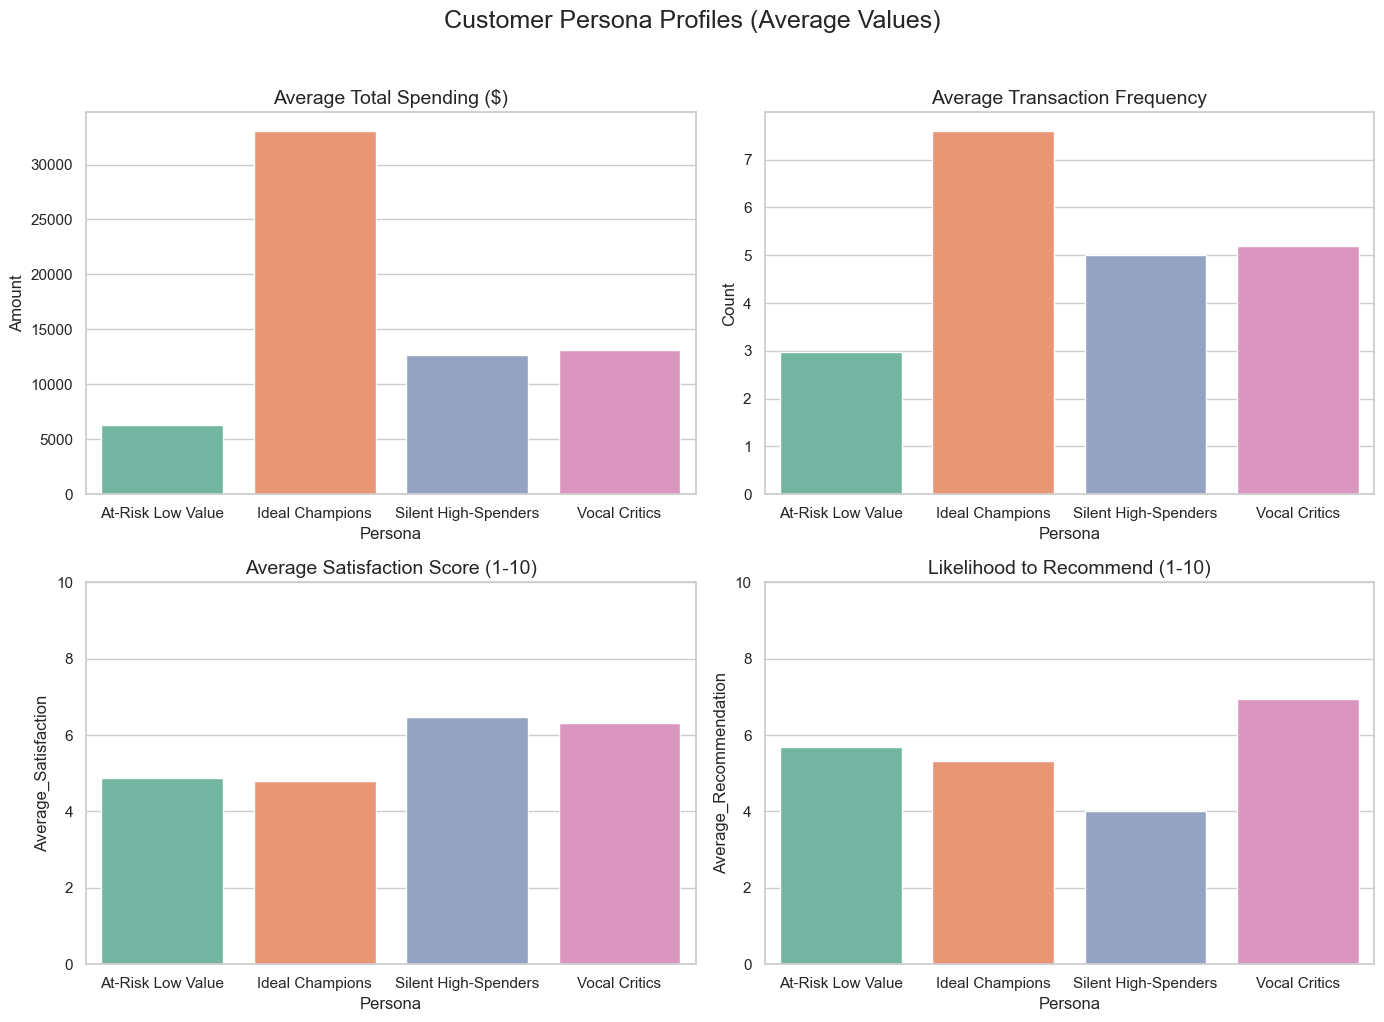

In [13]:
# Create a 2x2 grid of bar charts to visualize the Persona characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Customer Persona Profiles (Average Values)', fontsize=18, y=1.02)

# 1. Spending Chart
sns.barplot(ax=axes[0, 0], x=cluster_profiles.index, y=cluster_profiles['Total_Spending'], palette='Set2')
axes[0, 0].set_title('Average Total Spending ($)', fontsize=14)
axes[0, 0].set_ylabel('Amount')

# 2. Frequency Chart
sns.barplot(ax=axes[0, 1], x=cluster_profiles.index, y=cluster_profiles['Transaction_Frequency'], palette='Set2')
axes[0, 1].set_title('Average Transaction Frequency', fontsize=14)
axes[0, 1].set_ylabel('Count')

# 3. Satisfaction Chart
sns.barplot(ax=axes[1, 0], x=cluster_profiles.index, y=cluster_profiles['Average_Satisfaction'], palette='Set2')
axes[1, 0].set_title('Average Satisfaction Score (1-10)', fontsize=14)
axes[1, 0].set_ylim(0, 10)

# 4. Recommendation Chart
sns.barplot(ax=axes[1, 1], x=cluster_profiles.index, y=cluster_profiles['Average_Recommendation'], palette='Set2')
axes[1, 1].set_title('Likelihood to Recommend (1-10)', fontsize=14)
axes[1, 1].set_ylim(0, 10)

# Clean up layout and display
plt.tight_layout()
plt.show()

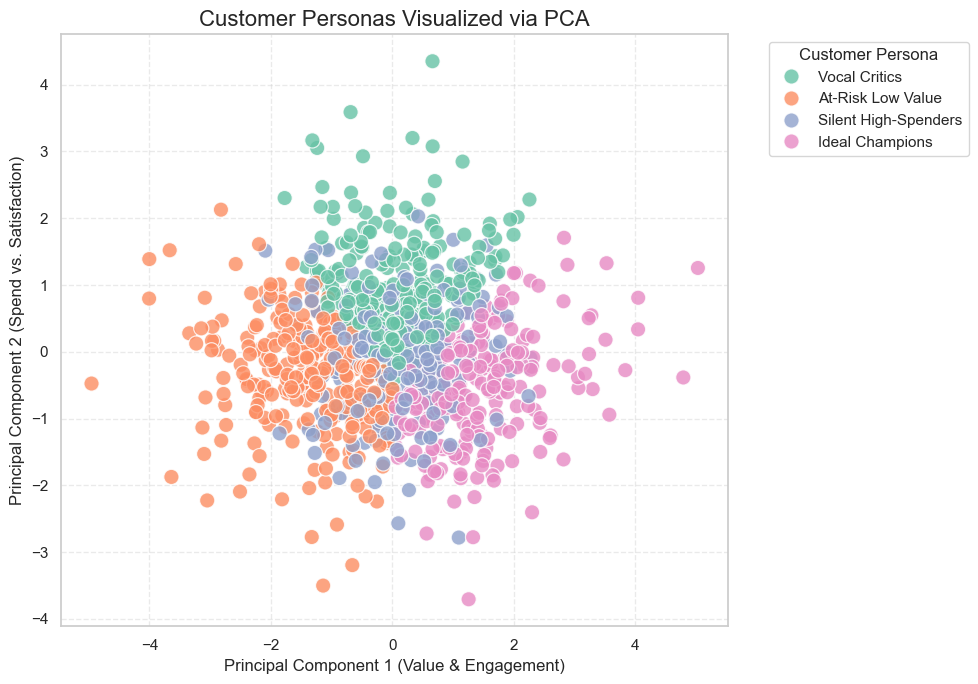

In [14]:
from sklearn.decomposition import PCA

# 1. Compress the scaled 4D data into 2 Principal Components
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# 2. Create a DataFrame for plotting
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
pca_df['Persona'] = df_cluster_ready['Persona'].values

# 3. Create the Scatter Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df, 
    x='PC1', 
    y='PC2', 
    hue='Persona', 
    palette='Set2', 
    s=120,          # Size of the dots
    alpha=0.8,      # Slight transparency to see overlapping dots
    edgecolor='w'
)

# 4. Add labels explaining what the axes mean based on PCA loadings
plt.title('Customer Personas Visualized via PCA', fontsize=16)
plt.xlabel('Principal Component 1 (Value & Engagement)')
plt.ylabel('Principal Component 2 (Spend vs. Satisfaction)')
plt.legend(title='Customer Persona', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()